In [1]:
%matplotlib inline
from scipy.stats import rv_continuous
from scipy.special import gamma
import numpy as np
from numpy import exp, sqrt
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
import hast
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe

In [2]:
path = "/data/MIB/anunez/NewSchool/Andorra/An_box25Mpc_hydro_Z_halo1/output_00041"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars")

loading Dark matter..
loading Gas..
loading Stars..


In [3]:
myhalo.r_virial(600,n=4)
print myhalo.r200

| r_200 = 218.848500778
---- taking particles inside 4 * r200
| number of praticles inside 4 * r200 
| dm mass       =  1.89904257024e+12 M_sun
| p_dm_200      =  1114609 particles
| stellar mass  =  1.91107579904e+11 M_sun
| p_st_200      =  3762264 psrticles
| gas mass      =  1.5733088256e+11 M_sun
| p_gs_200      =  2223978 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |17,0,0|
| D =|0,13,0|
|    |0,0,7|
218.848500778


## Escape velocity $v(r)$

## From ramses directly

In [4]:
r_gas = myhalo.gs.r 
r_max_condition = (r_gas < 3* myhalo.r200 + 4.)&(r_gas > 3* myhalo.r200 - 4.)
PHI_rmax = np.mean(myhalo.gs.pot[r_max_condition])  * myhalo.gs._p.simutokms**2




In [5]:
unit_t      =  0.454735724353090E+18
print ((myhalo.gs._p.pctocm * 1e-2 )**2 / unit_t**2)**2
print myhalo.gs._p.simutokms

2.12014656194e-05
2504.45389407


In [6]:
r_sample = np.logspace(-0,np.log10(myhalo.r200),50)
def PHI(r):
    r_condition = ( myhalo.gs.r < r + 0.98)&(myhalo.gs.r > r - 0.98)
    return np.mean(myhalo.gs.pot[r_condition]) * myhalo.gs._p.simutokms**2

get_PHI = np.vectorize(PHI)
PHI_r = get_PHI(r_sample)

In [7]:
%%latex
the escape velocity is defined as:
\begin{equation}
v_{esc}(r) = \sqrt{2|\Phi(r) - \Phi(r_{max})|}
\end{equation}
where we consider $\Phi(r_{max})$ the potential at $ r_{max} = 3r_{200}$

<IPython.core.display.Latex object>

In [8]:
v_esc = np.sqrt(2 * abs(PHI_r - PHI_rmax))

In [9]:
print len(v_esc * myhalo.gs._p.simutokms),len(r_sample)

50 50


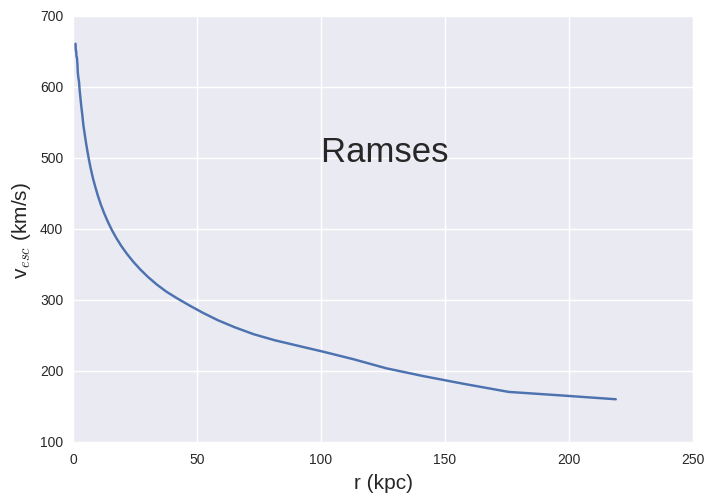

In [10]:
fig, ax = plt.subplots()
ax.plot(r_sample,v_esc)
ax.set_xlabel("r (kpc)",fontsize=15)
ax.set_ylabel(r'v$_{esc}$ (km/s)',fontsize=15)
ax.text(100,v_esc[0] * 3. /4.,"Ramses ",fontsize=25)

### From C-falcon


### 1) Dark matter

In [11]:
import cfalcon
CF =cfalcon.CFalcon()

In [28]:
pos = np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32)

ok, acc, Phy = CF.getGravity(pos,myhalo.dm.mass,0.5)

In [37]:
r_dm = myhalo.dm.r 
r_max_condition_dm = (r_dm < 3* myhalo.r200 + 4.)&(r_dm > 3* myhalo.r200 - 4.)
PHI_rmax_dm = np.mean(Phy[r_max_condition_dm]) * 6.67384e-2 * myhalo.dm._p.msuntokg

r_sample = np.logspace(-0,np.log10(myhalo.r200),50)
def PHI_DM(r):
    r_condition = ( myhalo.dm.r < r + 0.98)&(myhalo.dm.r > r - 0.98)
    return np.mean(Phy[r_condition]) *6.67384e-2 * myhalo.dm._p.msuntokg


get_PHI_DM = np.vectorize(PHI_DM)
PHI_dm = get_PHI_DM(r_sample)
v_esc_dm = np.sqrt(2 * abs(PHI_dm - PHI_rmax_dm))

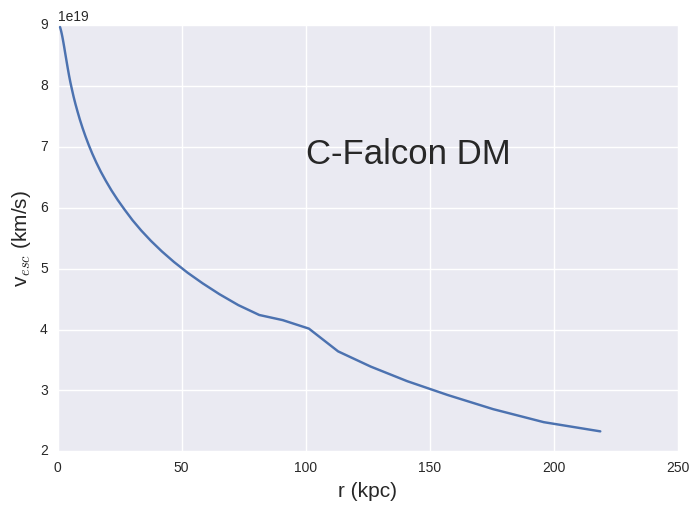

In [38]:
fig, ax = plt.subplots()
ax.plot(r_sample,v_esc_dm)
ax.set_xlabel("r (kpc)",fontsize=15)
ax.set_ylabel(r'v$_{esc}$ (km/s)',fontsize=15)
ax.text(100,v_esc_dm[0]*3/4.,"C-Falcon DM",fontsize=25)

### 2) Stars

In [15]:
pos = np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32)

ok, acc, Phy = CF.getGravity(pos,myhalo.st.mass,0.5)

r_st = myhalo.st.r 
r_max_condition_st = (r_st < 3* myhalo.r200 + 4.)&(r_st > 3* myhalo.r200 - 4.)
PHI_rmax_st = np.mean(Phy[r_max_condition_st])

r_sample = np.logspace(-0,np.log10(myhalo.r200),50)
def PHI_st(r):
    r_condition = ( myhalo.st.r < r + 0.98)&(myhalo.st.r > r - 0.98)
    return np.mean(Phy[r_condition])

get_PHI_st = np.vectorize(PHI_st)
PHI_st = get_PHI_st(r_sample)
v_esc_st = np.sqrt(2 * abs(PHI_st - PHI_rmax_st))

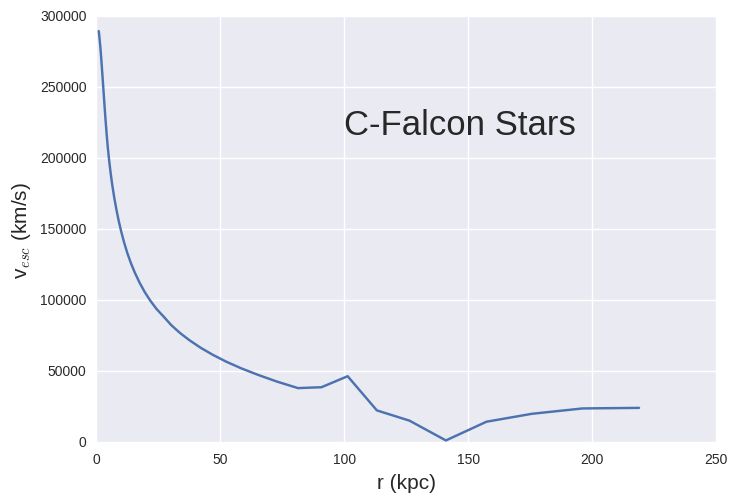

In [17]:
fig, ax = plt.subplots()
ax.plot(r_sample,v_esc_st)
ax.set_xlabel("r (kpc)",fontsize=15)
ax.set_ylabel(r'v$_{esc}$ (km/s)',fontsize=15)
ax.text(100,v_esc_st[0]*3/4,"C-Falcon Stars",fontsize=25)

### 3) Gas

In [18]:
pos = np.array(myhalo.gs.pos3d.reshape(len(myhalo.gs.pos3d)*3),dtype=np.float32)

ok, acc, Phy = CF.getGravity(pos,myhalo.gs.mass,0.5)

r_gs = myhalo.gs.r 
r_max_condition_gs = (r_gs < 3* myhalo.r200 + 4.)&(r_gs > 3* myhalo.r200 - 4.)
PHI_rmax_gs = np.mean(Phy[r_max_condition_gs])

r_sample = np.logspace(-0,np.log10(myhalo.r200),50)
def PHI_gs(r):
    r_condition = ( myhalo.gs.r < r + 0.98)&(myhalo.gs.r > r - 0.98)
    return np.mean(Phy[r_condition])

get_PHI_gs = np.vectorize(PHI_gs)
PHI_gs = get_PHI_gs(r_sample)
v_esc_gs = np.sqrt(2 * abs(PHI_gs - PHI_rmax_gs))

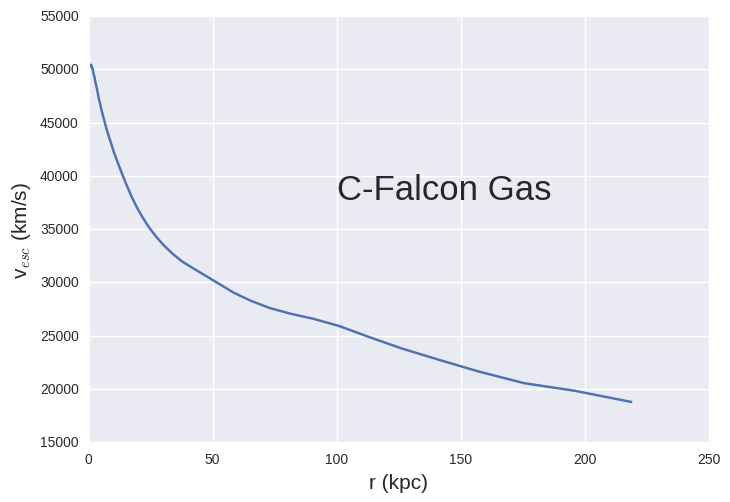

In [19]:
fig, ax = plt.subplots()
ax.plot(r_sample,v_esc_gs)
ax.set_xlabel("r (kpc)",fontsize=15)
ax.set_ylabel(r'v$_{esc}$ (km/s)',fontsize=15)
ax.text(100,v_esc_gs[0]*3/4,"C-Falcon Gas",fontsize=25)

### 4) Total

In [20]:
%%latex
here we consider $\Phi_{tot}$ as 
\begin{equation}
\Phi_{tot} = \Phi_{dm} + \Phi_{stars} + \Phi_{gas} 
\end{equation}

and the same for $\Phi(r_{max})$

<IPython.core.display.Latex object>

In [21]:
Phi_total = PHI_dm + PHI_st + PHI_gs
Phi_max_total =  PHI_rmax_dm + PHI_rmax_gs + PHI_rmax_st

In [22]:
v_esc_TOT = np.sqrt(2 * abs(Phi_total - Phi_max_total))

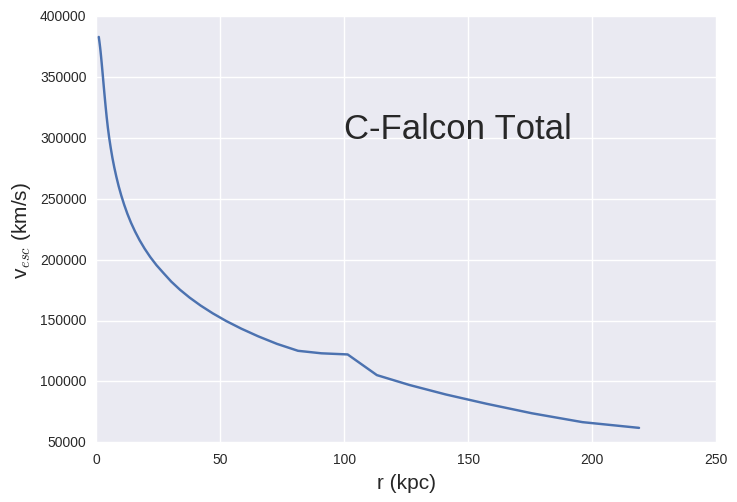

In [23]:
fig, ax = plt.subplots()
ax.plot(r_sample,v_esc_TOT)
ax.set_xlabel("r (kpc)",fontsize=15)
ax.set_ylabel(r'v$_{esc}$ (km/s)',fontsize=15)
ax.text(100,3e5,"C-Falcon Total",fontsize=25)

# Comparison

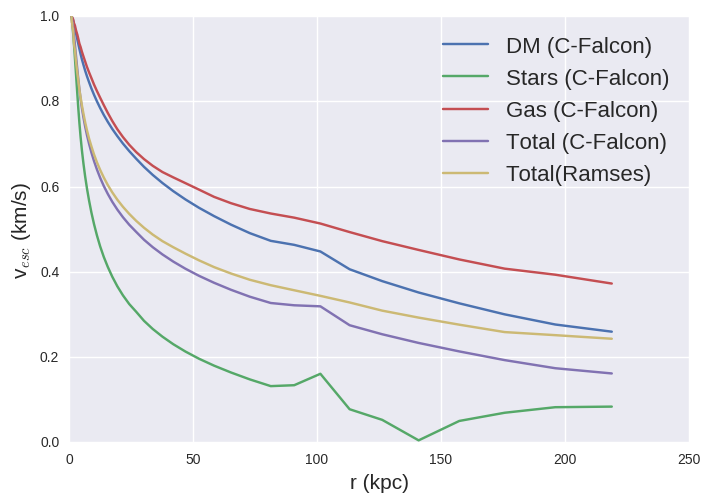

In [24]:
fig, ax = plt.subplots()
ax.plot(r_sample,v_esc_dm/v_esc_dm[0],label="DM (C-Falcon)")
ax.plot(r_sample,v_esc_st/v_esc_st[0],label="Stars (C-Falcon)")
ax.plot(r_sample,v_esc_gs/v_esc_gs[0],label="Gas (C-Falcon)")
ax.plot(r_sample,v_esc_TOT/v_esc_TOT[0],label="Total (C-Falcon)")
ax.plot(r_sample,v_esc/v_esc[0],label="Total(Ramses)")
ax.set_xlabel("r (kpc)",fontsize=15)
ax.set_ylabel(r'v$_{esc}$ (km/s)',fontsize=15)
legend = ax.legend(loc='cupper right', ncol=1, shadow=False, fontsize=16)

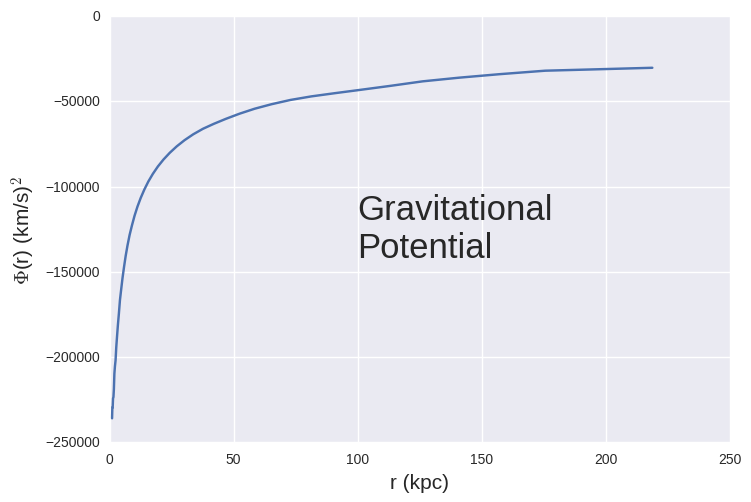

In [25]:
fig, ax = plt.subplots()
ax.plot(r_sample,PHI_r)
ax.set_xlabel("r (kpc)",fontsize=15)
ax.set_ylabel(r'$\Phi$(r) (km/s)$^2$',fontsize=15)
ax.text(100,PHI_r[0]*3/5,"Gravitational\nPotential", fontsize=25)